### **3D Protein Image Classification Model**
Image Classification Model that identifies proteins given an mrc file. Credit to [Tensorflow's documentation](https://www.tensorflow.org/tutorials/images/classification) for how to create an image segmentation model using their library.

In [20]:
# run on python 3.9.6
# import the following libraries to use for the model and visualizing its accuracy and loss
import matplotlib.pyplot as plt
import mrcfile
import numpy as np
import os
import pathlib
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Download + Explore the Dataset**

In [21]:
data_dir = "../../mrc/atlas-mrc"
data_dir = pathlib.Path(data_dir)

### **Process .mrc files**

In [22]:
batch_size = 4
img_height = img_width = img_depth = 100

In [23]:
def load_mrc_file(file_path):
    with mrcfile.open(file_path) as mrc:
        return mrc.data

In [24]:
def load_mrc_files_from_directory(directory):
    mrc_files = []
    labels = []

    # Iterate over subdirectories (classes)
    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Iterate over .mrc files in the current class directory
            for filename in sorted(os.listdir(class_dir)):
                if filename.endswith('.mrc'):
                    file_path = os.path.join(class_dir, filename)
                    # Load .mrc file
                    with mrcfile.open(file_path) as mrc:
                        mrc_data = mrc.data     # alternatively: .astype(np.float32)
                        mrc_files.append(mrc_data)
                        labels.append(class_index)

    return mrc_files, labels, class_names

In [25]:
mrc_files, labels, class_names = load_mrc_files_from_directory(data_dir)

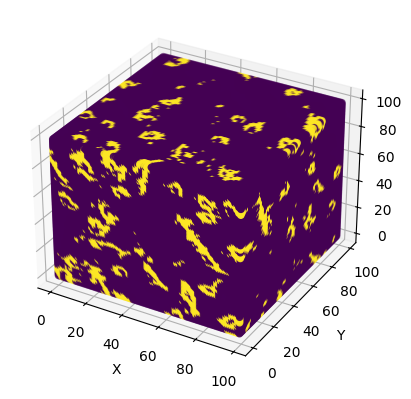

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a sample 3D numpy array
data = mrc_files[0]  # Replace this with your 3D numpy array

# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the shape of the data
x_size, y_size, z_size = data.shape

# Create arrays for the x, y, and z coordinates
x = np.arange(0, x_size)
y = np.arange(0, y_size)
z = np.arange(0, z_size)

# Create a meshgrid from the x, y, and z coordinates
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Plot the 3D array
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=data.flatten(), cmap='viridis')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

# Convert list of 3D numpy arrays to a single 4D numpy array
# Then, convert list of labels to a numpy array
x = np.array(mrc_files)
y = np.array(labels)

# Preprocessing (e.g., normalization)
x_normalized = x / 255.0

# Shuffle data
indices = np.arange(x.shape[0])
x_shuffled = x_normalized[indices]
y_shuffled = y[indices]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=0.2, random_state=42)

### **Load data using a Keras utility**

In [27]:
print(f"Training Dataset: {len(x_train)} tomograms and {len(y_train)} labels")
print(f"Validation Dataset: {len(x_val)} tomograms and {len(y_val)} labels")

Training Dataset: 48 tomograms and 48 labels
Validation Dataset: 12 tomograms and 12 labels


In [28]:
print(class_names)

['bltp2', 'coagulation', 'rif1']


### **TensorFlow Keras Model**

**Data Augmentation**<br>

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

**Creating the Model**<br>

In [40]:
num_classes = len(class_names)
ks = kernel_size = 5
ps = pool_size = 2

model = Sequential([
  layers.Conv3D(16, (ks, ks, ks), padding='same', activation='relu', input_shape=(img_depth, img_height, img_width, 1)),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(32, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(64, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(128, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

d:\Classes\CS562\ProteinPicker\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


**Compile and Train the Model**

In [41]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 100, 100, 100,  │         5,504 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 50, 50, 50, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 50, 50, 50, 32) │       175,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 25, 25, 25, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 25, 25, 25, 64) │       702,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 12, 12, 12, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 12, 12, 12,     │     2,809,984 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,772,579 (41.09 MB)

 Trainable params: 10,772,579 (41.09 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [44]:
epochs = 5
history = model.fit(x_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_val, y_val),
          callbacks=[callback]
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 195s 8s/step - accuracy: 0.5080 - loss: 7.9829 - val_accuracy: 0.1667 - val_loss: 13.4317
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.4274 - loss: 9.2290 - val_accuracy: 0.1667 - val_loss: 13.4317
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 198s 8s/step - accuracy: 0.3371 - loss: 10.6854 - val_accuracy: 0.1667 - val_loss: 13.4317
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.4080 - loss: 9.5423 - val_accuracy: 0.1667 - val_loss: 13.4317


In [45]:
import csv
d = history.history

n = len(d["loss"])
with open("callbacks_log.csv", "w") as f:
    csv_writer = csv.writer(f, lineterminator="\n")
    header = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
    csv_writer.writerow(header)

    for i in range(n):
        loss = d["loss"][i]
        accuracy = d["accuracy"][i]
        val_loss = d["val_loss"][i]
        val_accuracy = d["val_accuracy"][i]
        csv_writer.writerow([i, loss, accuracy, val_loss, val_accuracy])

**Visualize Training Results**

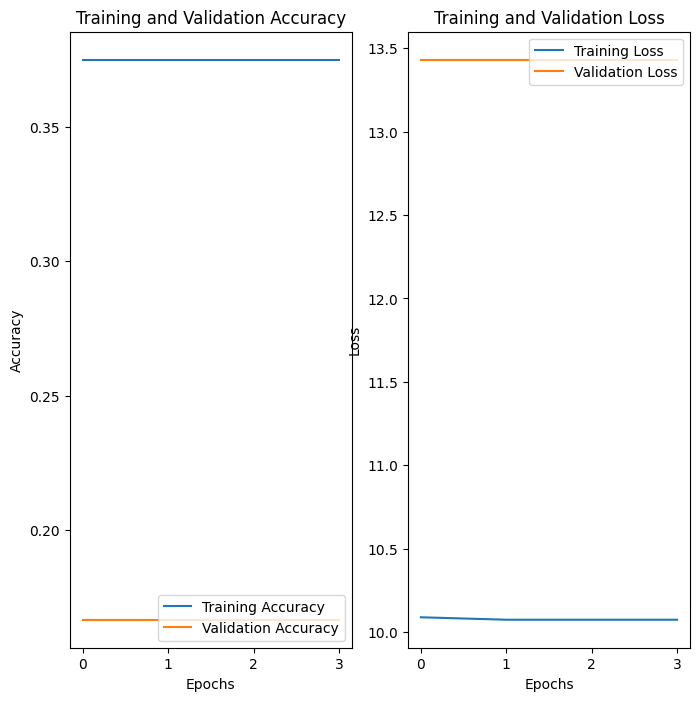

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

### **Predict on New Data**

In [47]:
test_path = "../../mrc/atlas-mrc/bltp2/atlas_BLTP2_4.mrc"
x_test = load_mrc_file(test_path)/255.0
x_test = np.expand_dims(x_test, axis=0)
x_test = x_test.reshape(-1, img_depth, img_height, img_width, 1)

predictions = model.predict(x_test)
score = tf.nn.softmax(predictions[0])

print(
    "This tomogram most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
This tomogram most likely belongs to coagulation with a 100.00 percent confidence.


### **Save the Model**

In [48]:
model.save('atlas_3d_model.keras')